## Import necessary modules, set up environment

In [282]:

from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgObsWrapper
from stable_baselines3 import PPO
import gymnasium



## Set up the wrappers for the environment

`MissionEncodingWrapper` adds one for every discrete space in the one-hot encoding of the mission, allowing 0 to be encoded as well.

`ImageFeaturesExtractor` extracts relevant features if the observation is just an image, used with `ImgObsWrapper`

`MinigridFeaturesExtractor` extracts relevant features from the entire observation, used with `MissionEncodingWrapper` and `DictObservationSpaceWrapper`

In [117]:

from gymnasium import ObservationWrapper
import numpy as np
# a custom wrapper to make the mission vector work with one hot encoding
class MissionEncodingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['mission'] = spaces.MultiDiscrete(np.array([n+1 for n in env.observation_space['mission'].nvec]))
    def observation(self, obs):
        return obs

In [118]:
class ImageFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gymnasium.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [119]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
       
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

### Train the model and save it. -- also try `FlatObsWrapper`

Dict('direction': Discrete(4), 'image': Box(0, 255, (152, 152, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x11a0e6d40>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))
(608, 608, 3)


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN

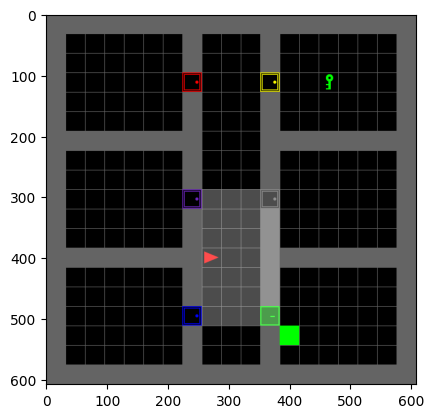

In [205]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
# env = DictObservationSpaceWrapper(env)
# env = MissionEncodingWrapper(env)
env = RGBImgObsWrapper(env)

print(env.observation_space)
env.reset()
r = env.render()
print(r.shape)
plt.imshow(r)

In [56]:
class Actions:
    LEFT = 0
    RIGHT = 1
    FORWARD = 2
    PICKUP = 3
    DROP = 4
    TOGGLE = 5
    DONE = 6

DIRECTION:
Up: 3
Left: 2
Down: 1
Right: 0

In [121]:

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env) # so that the multidiscrete mission space is 51, accounting for values 0 through 50
env.metadata['render_modes'] = ["rgb_array"]


model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(2e5)

## the problem: ppo requires a gym env to train. but the env observation space is of type gymnasium.spaces. 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


KeyboardInterrupt: 

### Record Video of the trained policy

In [337]:
from utils import record_videos, show_videos

model = PPO.load("minigrid_models/minigrid_custom/2")

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env) 
env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-2', episode_trigger=lambda e: e % 2 == 0)

obs, info = env.reset()
done = False
env.start_video_recorder()
steps = 0
while not done and steps <= 50000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
    steps += 1
env.close_video_recorder()
env.close()
show_videos()

Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-2/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-2/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-2/rl-video-episode-0.mp4
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-2/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-2/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-2/rl-video-episode-0.mp4


## How to render image

-- good for passing into GPT4 VLM

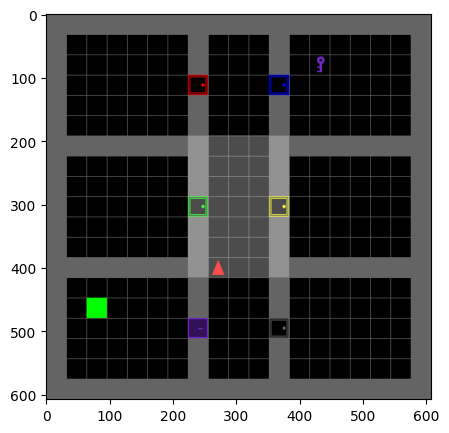

In [123]:
env.reset()
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

## Custom Reward Function

In [327]:
from openai import OpenAI
from api.settings import Settings

openai_client = OpenAI(api_key=Settings().openai_key)

def vision(prompt_text: str, img_base64: str):
    """Run a GPT-4 vision model on the prompt text and image.

    ```
    from PIL import Image
    im = Image.fromarray(r)
    vision("what do you see?", image_to_base64(im))
    ```
    """
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img_base64}",
                        "detail": "low"
                    },
                },
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=600,
    )
    return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=300,
    )
    return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=600,
    )
    return response



## Custom Reward

In [308]:
image_env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array") # filler env to get the render
ob, info = image_env.reset()
render = image_env.render()
ob['mission']

'get the red key from the grey room, unlock the red door and go to the goal'

In [341]:
prompt1 = '''You are an assistant aiding with subgoal generataion for reinforcement learning problems. Specifically, you will
be given an image of an environment and a textual goal description, and you are to output language subgoals that the agent should
achieve in order to efficiently and successfully achieve the main goal. These subgoals should be with respect to the image itself:
they should specify specific observations that show that the agent is on track. Output a list of ONLY these text subgoals in the following format:

- [subgoal 1]
- [subgoal 2]
- ...

where [subgoal i] is replaced by the ith subgoal. You should output 5 (five) subgoals Do not create directional subgoals but rather strategic
subgoals that do not hard code the direction but instead tell the agent which states are more beneficial.

Here, the main goal description is 
''' + ob['mission'] + ' where the goal is the light green square.'

prompt2 = '''
You are an assistant tasked with turning language subgoals into machine readable code. You will be given a text subgoals, and you must translate these subgoals into code that takes in an observation of the format

{'direction': Discrete(4), image: np.ndarray}

where image is of shape (7x7x3), and the final dimension corresponds to RGB colors. Each 7x7 subarray corresponds to the agent's view. Furthermore, direction corresponds to an enumeration where

Up: 3
Left: 2
Down: 1
Right: 0

and each image observation is centered such that the agent is facing the entire observation and none of the image observation is behind the agent, and it can only see in front and to the side of itself.

Output the subgoal as a python function that takes in the observation and returns a reward function that prioritizes the specific subgoal.
This reward function should be dense; it should make the agent want to move closer to the specific subgoal. Have the maximum reward of the function be 0 (where the goal is obtained).
You can do this by locating the subgoal in the image observation and using a distance metric to output a dense reward based on it.
The code should be the only thing you output, all in one python function without sub functions. Name each function `reward_i` where i is ''' # add i

In [312]:
from PIL import Image
from api.image import image_to_base64

im = Image.fromarray(render)
completion1 = vision(prompt1, image_to_base64(im))

In [313]:
print(completion1.choices[0].message.content)

- Locate and enter the grey room where the red key is visible.
- Acquire the red key found in the grey room.
- Identify and approach the red door that can be unlocked with the red key.
- Use the red key to unlock the red door.
- Move towards and reach the light green square, which is designated as the goal.


In [342]:
im = Image.fromarray(render)
completions = []
for i, sg in enumerate(completion1.choices[0].message.content.splitlines()):
    completions.append(complete(prompt2 + str(i) + '\nThe textual subgoal is as follows: ' + sg))

In [343]:
completion_funcs = [c.choices[0].message.content for c in completions]
completion_funcs_execute = ['\n'.join(c.splitlines()[1:-1]) for c in completion_funcs]
for c in completion_funcs_execute:
    print(c)
    exec(c)

import numpy as np

def reward_0(observation):
    direction = observation['direction']
    image = observation['image']
    
    # Define RGB values for red and grey
    red_rgb = np.array([255, 0, 0])
    grey_rgb = np.array([128, 128, 128])
    
    # Initialize reward
    reward = 0
    
    # Check for presence of red key and grey room
    red_key_present = False
    grey_room_present = False
    
    # Calculate the center of the image
    center_x, center_y = 3, 3
    
    # Search for red key and grey room in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Check if the current pixel is red (key)
            if np.array_equal(image[i, j], red_rgb):
                red_key_present = True
                # Calculate distance to red key from the center
                distance_to_key = np.sqrt((center_x - i)**2 + (center_y - j)**2)
                # Update reward based on distance to red key
                reward -= distance_to_k

In [331]:
class CustomRewardWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['subgoals_achieved'] = spaces.MultiBinary(5)
    def observation(self, obs):
        for i, reward_func in enumerate([reward_0, reward_1, reward_2, reward_3, reward_4]):
            reward = reward_func(obs)
            epsilon = 0.4
            if reward > -epsilon:
                obs['subgoals_achieved'][i] = 1
        return obs

In [344]:
# custom_parking_env.py
from typing import Callable

from gymnasium.envs.registration import register
from minigrid.envs.lockedroom import LockedRoomEnv

from gymnasium import spaces

import numpy as np


class CustomMinigridEnv(LockedRoomEnv):
    def __init__(
        self,
        *args,
        compute_reward: Callable[["CustomMinigridEnv", spaces.Dict], float],
        **kwargs
    ):
        self.compute_reward_func = compute_reward
        super().__init__(*args, **kwargs)
        
    def compute_reward(self, current_state: spaces.Dict) -> float:
        return self.compute_reward_func(self, current_state)



register( id="CustomLockedRoom-v0", entry_point=CustomMinigridEnv)

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CustomLockedRoom-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [345]:
EPSILON = 0.01
def generate_total_reward():
    current_subgoal = 0
    subgoals = [reward_0, reward_1, reward_2, reward_3, reward_4]
    def total_reward(obs):
        if current_subgoal == 5:
            return 1.0

        reward = subgoals[current_subgoal](obs)
        if reward > -EPSILON:
            current_subgoal += 1
        
        return reward
                
        # return max(reward(obs) for i, reward in enumerate([reward_0, reward_1, reward_2, reward_3, reward_4]) if i not in achieved_subgoals)
    
    return total_reward

env = gymnasium.make("CustomLockedRoom-v0", render_mode = "rgb_array", compute_reward = generate_total_reward())
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env) 


In [346]:
model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(2e5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 195      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 190        |
|    ep_rew_mean          | 0          |
| time/                   |            |
|    fps                  | 132        |
|    iterations           | 2          |
|    time_elapsed         | 30         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00928688 |
|    clip_fraction        | 0.041      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | -3.29      |
|    learning_rate        | 0.0003     |
|   

In [347]:
model.save("minigrid_models/minigrid_custom/4-iterative-subgoals")

In [286]:
env = gymnasium.make("CustomLockedRoom-v0", render_mode = "rgb_array", compute_reward = generate_total_reward())
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)
model = PPO.load("minigrid_models/minigrid_custom/1")
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
